# Compare Changes in the Graph with Current Price Data

Load here the needed libraries and data. Also, filter the data we treat. Finally, choose a time window by computing a column e.g. days, days with hour, etc.

In [2]:
import sys

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from degree_centrality import DegreeCentrality
from current_price_fetcher import CurrentPriceFetcher

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

Load the edgelist into a pandas frame for preprocessing.

In [3]:
edges = pd.read_csv('../data/csv/edges_deep_link_no_merge.csv')

#prepare human readable time
edges['human_time'] = pd.to_datetime(edges['time'], unit='s').dt.date
edges['human_time_hour'] = pd.to_datetime(edges['time'], unit='s').dt.strftime('%Y-%m-%d %H')

#filter data from to
date_from = pd.to_datetime("2022-4-1").date()
date_to = pd.to_datetime("2022-5-24").date()
frame = edges[(edges['human_time'] >= date_from) & (edges['human_time'] < date_to)]

data = frame.sort_values(by='time')

data

,source,target,score,weight,time,sub,human_time,human_time_hour
60362,chadtastic,NeedleworkerNo2874,1,1.0,1.648772e+09,Bitcoin,2022-04-01,2022-04-01 00
60363,BrubMomento,NeedleworkerNo2874,1,1.0,1.648773e+09,Bitcoin,2022-04-01,2022-04-01 00
26413,AESTHTK,Solodeji,24,24.0,1.648773e+09,Ethereum,2022-04-01,2022-04-01 00
26404,tommyjangles22,muradphy,3,3.0,1.648773e+09,Ethereum,2022-04-01,2022-04-01 00
59990,noctis89,NeedleworkerNo2874,0,0.0,1.648773e+09,Bitcoin,2022-04-01,2022-04-01 00
...,...,...,...,...,...,...,...,...
113487,Heph333,notdsylexic,1,0.5,1.653350e+09,Bitcoin,2022-05-23,2022-05-23 23
113486,Heph333,PumperNikel0,1,1.0,1.653350e+09,Bitcoin,2022-05-23,2022-05-23 23
113485,Heph333,PusghettiBoy93,1,1.0,1.653350e+09,Bitcoin,2022-05-23,2022-05-23 23
48931,Romando1,Black_Labs_Matter69,4,4.0,1.653350e+09,Bitcoin,2022-05-23,2022-05-23 23


## Preprocessing: Activity computation

We want to analyze graph development, i.e. the interactions over time. To do so, we will create a list of cumulitative subsets which correspond to a time window. Each subset is a subset of the next time window, i.e. $day[0] \subset day[1] ...$

In [18]:
# returns [(date1,pd frame1), (date1,pd frame2), (date1,pd frame3)...]
# pass key fct to overwrite key (date1,...)

def increasing_table_inclusion(df, by='human_time', key=None):
    disj_days = list(df.groupby(by, as_index=False))

    first_day = disj_days[0]
    first_key = key(0, first_day) if key is not None else first_day[0]
    
    cumulated = [ (first_key,first_day[1]) ]
    
    for i, day in enumerate(disj_days,start=0):
        if i > 0: #skip first day
            i_key = key(i, day) if key is not None else day[0]
            frame_so_far = pd.concat([cumulated[i-1][1], day[1]])
            cumulated.append(
                (i_key, 
                 frame_so_far
                )
            )
            
    return cumulated

Now, let's create networkx graph instances of these edgelists to analyze them.

In [19]:
Gs = []
time_key = lambda _,d: pd.to_datetime(f'{d[0]}:00')

for time, cum_days in increasing_table_inclusion(data, by="human_time_hour"):
    Gs.append(
        (time, 
         nx.from_pandas_edgelist(
             cum_days, create_using=nx.MultiDiGraph(), source='source', target='target', 
             edge_attr=['score', 'weight', 'time', 'sub'])
        )
    )

Next, we want to compute the differences between each timeframe. We provide here two possible difference functions. One in percentage and one in absolute value.

In [20]:
def compute_diff_prc(row,col):
    old = row[f'{col}_old']
    new = row[f'{col}_new']
    
    if old > 0:
        return (new / old - 1) * 100
    else:
        return 0
    
def compute_diff_abs(row,col):
    old = row[f'{col}_old']
    new = row[f'{col}_new']
    
    return new - old

def compute_nodes_degree_difference(G1, G2, f=None, cols=None):
    dc = DegreeCentrality()
    df1 = dc.compute_degree_centrality(G1)
    df2 = dc.compute_degree_centrality(G2)
    
    if cols is None:
        cols = { col : [] for col in list(df2.columns)}
        
    if f is None:
        f = compute_diff_prc
    
    diff = pd.DataFrame(cols)
    
    j = df1.join(df2, how='inner', lsuffix='_old', rsuffix='_new')
    
    for col in cols:
        diff[col] = j.apply(lambda row: f(row,col), axis=1)
        
    s = j.reindex(sorted(j.columns), axis=1)
    
    diff.drop(labels=['[deleted]'], axis=0, inplace=True,errors='ignore') #remove deleted posts
    
    
    return diff

Compute the differences.

**Attention**: This code block will require significant amount of time to compute and needs up to 50GB of RAM.

In [21]:
differences = [ 
    (Gs[i][0], #date
     compute_nodes_degree_difference(Gs[i][1], Gs[i+1][1], f=compute_diff_prc) #frame
    ) 
    for i in range(len(Gs) - 1) 
]

Finally, we can prepare our data for plotting

In [50]:
degrees_list = [ df.rename(columns={"degree": date} )[date] for date,df in differences ]

degrees = pd.concat(degrees_list, axis=1)

#dropzero rows
degrees = degrees.loc[~(degrees==0).all(axis=1)]

#fill nan with 0
degrees.fillna(0, inplace=True)
degrees.reset_index(drop=True,inplace=True) #drop user names

Let's quickly reduce our data size to plot something meaningful

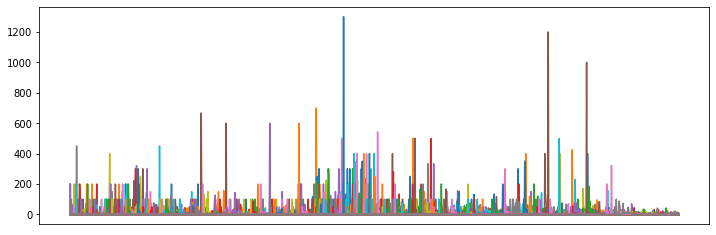

In [53]:
cols = list(degrees.columns)
plot_data = degrees[np.count_nonzero(degrees.values, axis=1) > len(degrees.columns)/30] #reduce for plotting
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xticks([], [])
plt.plot(plot_data.T)
plt.show()

In [4]:
#degrees.to_csv("degrees.csv")
degrees = pd.read_csv('degrees.csv', index_col=0) #use this to not recompute degrees since it takes forever

Let's sum up each row and see how it develops; each row represents one user, each column represents one time window.

<AxesSubplot:>

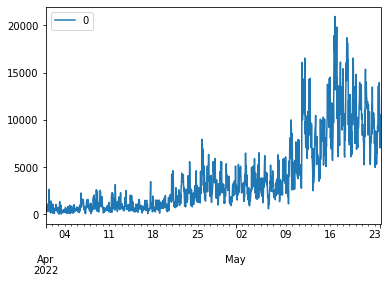

In [5]:
sums = pd.DataFrame(degrees.apply(lambda col: sum(col), axis=0))
sums.index = pd.to_datetime(sums.index)

sums.plot()

Compute & plot moving average.

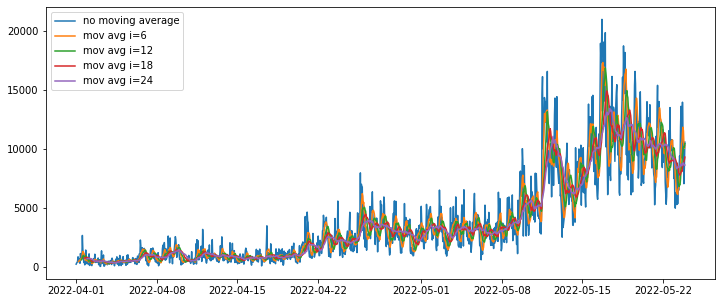

In [48]:
ma_windows = range(2,) #compute for steps 2 to 20

ma_sums = pd.DataFrame({})

fig, ax = plt.subplots(figsize=(12, 5))

plt.plot(sums[0])
leg = ['no moving average']

ma_sums['ma_0'] = sums[0]

for i in ma_windows:
    ma_sums[f'ma_{i}'] = sums[0].rolling(i).mean()
    if i % 6 == 0:
        plt.plot(ma_sums[f'ma_{i}'])
        leg.append(f'mov avg i={i}')

plt.legend(leg)
plt.savefig('plots/sums_ma.pdf')
plt.show()

## Preprocessing: Price computation

Load the price data and preprocess.

In [49]:
df = pd.read_csv('../data/price/BTC-USD-2022-04-01.csv')
df['human_time'] = pd.to_datetime(df['unix'], unit='s').dt.date
df['human_time_hour'] = pd.to_datetime(df['unix'], unit='s').dt.strftime('%Y-%m-%d %H')
frame = df[(df['human_time'] >= date_from) & (df['human_time'] < date_to)]

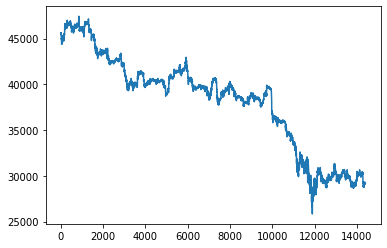

In [50]:
plt.plot(frame['close'])

plt.show()

Compute moving average also for price.

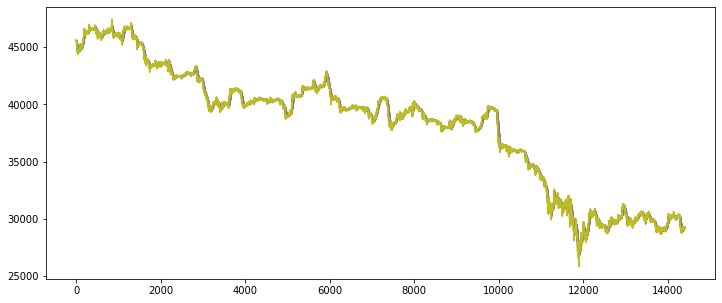

In [51]:
ma_closes = pd.DataFrame({})
f = frame['close'] #column to use


ma_closes['ma_0'] = f

fig, ax = plt.subplots(figsize=(12, 5))

for i in ma_windows:
    
    step = (len(f)/len(sums)) #since len(closes) > len(sums) and we want to roll "over the same time"
    ma_closes[f'ma_{i}'] = f.rolling(int(2*i)).mean()
    plt.plot(ma_closes[f'ma_{i}'])

plt.plot(ma_closes['ma_0'])


ma_closes['dt'] = pd.to_datetime(frame['unix'], unit='s')
ma_closes.set_index('dt', inplace=True)


Plot price over set of moving windows of sums.

In [52]:
normalized_sums = (ma_sums-ma_sums.mean())/ma_sums.std()
normalized_closes = (ma_closes-ma_closes.mean())/ma_closes.std()

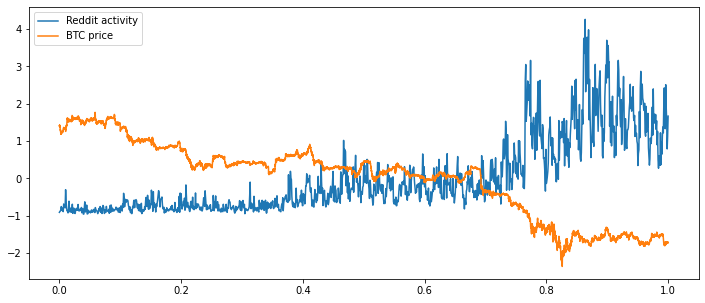

In [73]:
fig, ax = plt.subplots(figsize=(12, 5))

x1 = np.linspace(0, 1, len(normalized_sums))
x2 = np.linspace(0, 1, len(normalized_closes))
plt.plot(x1, normalized_sums[f'ma_0'])
plt.plot(x2, normalized_closes[f'ma_0'])
plt.legend(['Reddit activity', 'BTC price'])
plt.savefig('plots/activity_x_price.pdf')
plt.show()

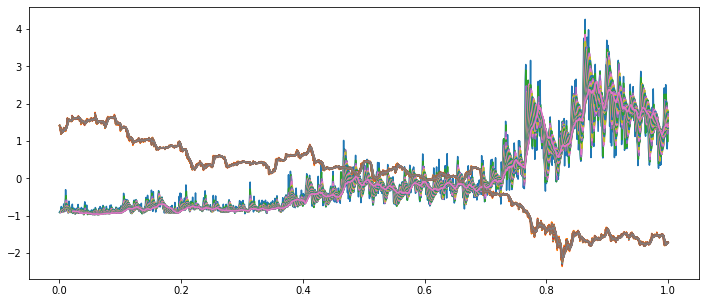

In [53]:
l = list(ma_windows)
l.insert(0,0)

fig, ax = plt.subplots(figsize=(12, 5))

for i in l:
    x1 = np.linspace(0, 1, len(normalized_sums))
    x2 = np.linspace(0, 1, len(normalized_closes))

    plt.plot(x1, normalized_sums[f'ma_{i}'])
    plt.plot(x2, normalized_closes[f'ma_{i}'])

plt.savefig('plots/x_ma.pdf')
plt.show()

Finally, resample our data and then join.

In [54]:
resampled = normalized_closes.resample('60min').mean()

joined_data = normalized_sums.join(resampled, how='inner', lsuffix='_activity', rsuffix='_close')

## Try to correlate

Let's facilitate our work by first writing some functions

In [64]:
def compute_corr(df, method):
    r=[]
    for p in ma_windows:
        for a in ma_windows:
            pair = [f'ma_{p}_activity',f'ma_{a}_close']
            j = df[pair].dropna()
            corr = method(j)

            v = abs(corr[0][1]) + abs(corr[1][0])

            r.append((v,corr,j,pair))

    best_result = sorted(r, key=lambda tup: -tup[0])

    return best_result

def plot_corr(corr,pref=""):
    fig, ax = plt.subplots(figsize=(12, 5))
    corr[2].plot(ax=ax)
    plt.savefig(f'plots/corr_{pref}_{i}.pdf')

def spearman(df):
    return df.corr(method="spearman").values

def pearson(df):
    return df.corr(method="pearson").values

def kendall(df):
    return df.corr(method="kendall").values

Set our dates from when to when we want to correlat the data

In [65]:
fr = '2022-04-01 00:00:00'
to = '2022-05-24 00:00:00'

Now, let's compute the 5 best correlations for spearman

Correlation for ['ma_20_activity', 'ma_29_close']:
[[ 1.         -0.90329789]
 [-0.90329789  1.        ]]
Correlation for ['ma_20_activity', 'ma_28_close']:
[[ 1.         -0.90325169]
 [-0.90325169  1.        ]]
Correlation for ['ma_20_activity', 'ma_27_close']:
[[ 1.         -0.90313584]
 [-0.90313584  1.        ]]


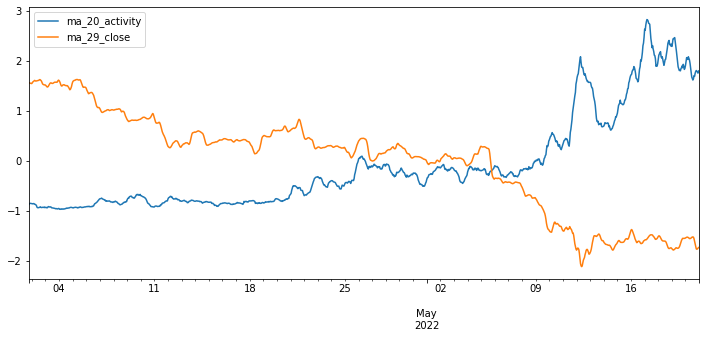

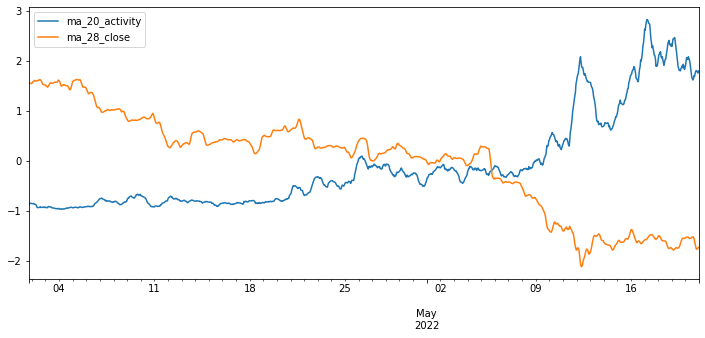

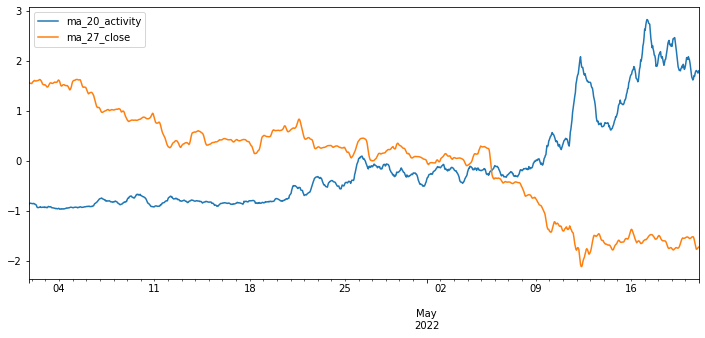

In [66]:
d = joined_data[fr:to]
sp = compute_corr(d, spearman)

for i in range(3):
    s = sp[i]
    plot_corr(s, "spearman")
    print(f"Correlation for {s[3]}:\n{s[1]}")

Let's do the same for pearson

Correlation:
[[ 1.         -0.88872079]
 [-0.88872079  1.        ]]
Correlation:
[[ 1.         -0.88867007]
 [-0.88867007  1.        ]]
Correlation:
[[ 1.        -0.8886367]
 [-0.8886367  1.       ]]


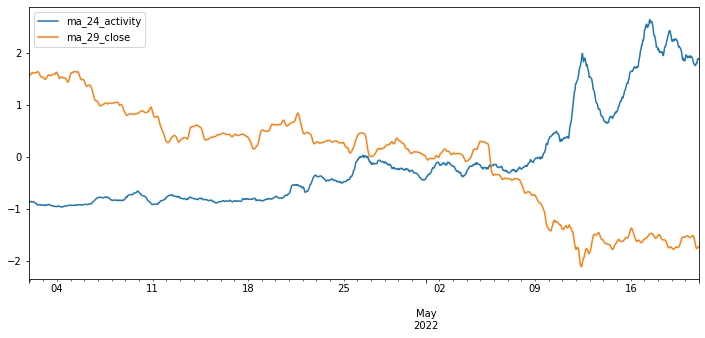

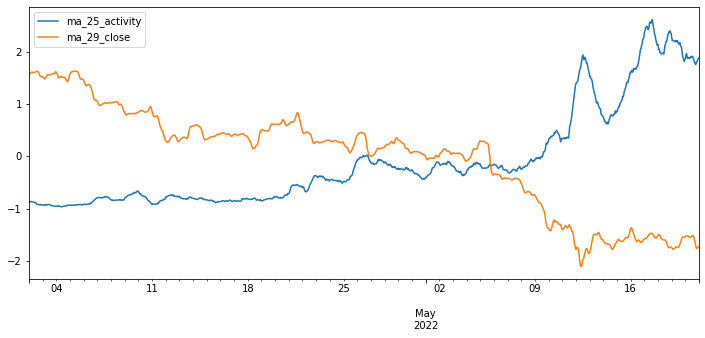

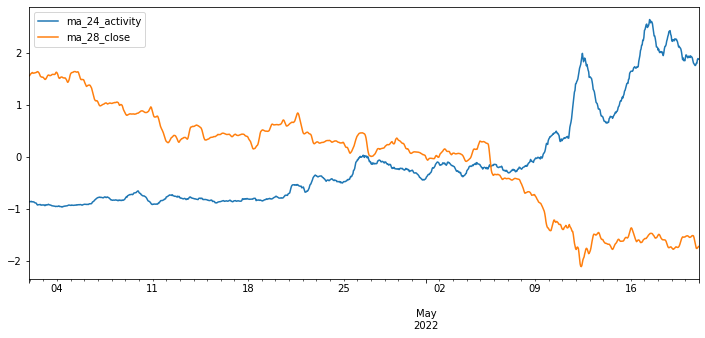

In [67]:
d = joined_data[fr:to]
sp = compute_corr(d, pearson)
for i in range(3):
    s = sp[i]
    plot_corr(s, "pearson")
    print(f"Correlation:\n{s[1]}")

## Try HSIC


In [82]:
f = joined_data[fr:to]
len(f[[f'ma_2_activity',f'ma_3_close']].dropna().to_numpy().T[0])

1199

In [92]:
import numpy
from hsic import dHSIC


d = joined_data[fr:to]

r=[]
for p in ma_windows:
    for a in ma_windows:
        pair = [f'ma_{p}_activity',f'ma_{a}_close']
        j = d[pair].dropna()

        np_j = j.to_numpy().T
        x = np.array(np_j[0])
        y = np.array(np_j[1])

        v = dHSIC(x, y)
        r.append((v,j,pair))


sort = sorted(r, key=lambda tup: -tup[0])

,ma_24_activity,ma_29_close
2022-04-01 23:00:00,-0.870609,1.555085
2022-04-02 00:00:00,-0.865270,1.554374
2022-04-02 01:00:00,-0.866399,1.570848
2022-04-02 02:00:00,-0.866794,1.588875
2022-04-02 03:00:00,-0.859786,1.596476
...,...,...
2022-05-20 19:00:00,1.796331,-1.758820
2022-05-20 20:00:00,1.791912,-1.765642
2022-05-20 21:00:00,1.863247,-1.757752
2022-05-20 22:00:00,1.886124,-1.744542


#1: Correlation:
0.07058173300717975
#2: Correlation:
0.07056607984433985
#3: Correlation:
0.07055963894337494


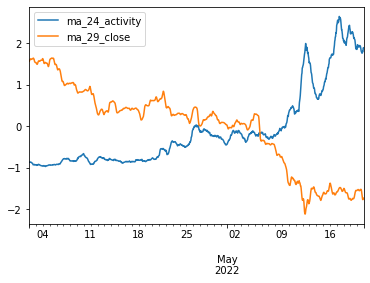

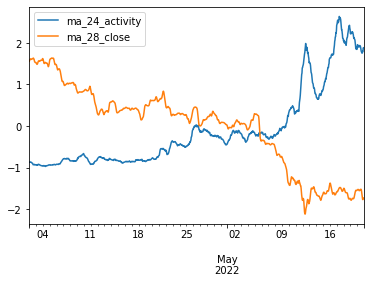

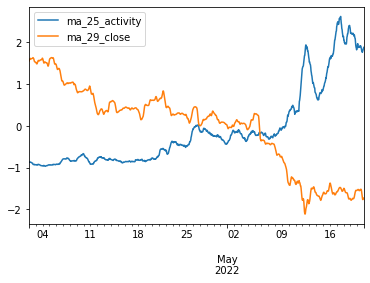

In [98]:
for i in range(3):
    s = sort[i]
    s[1].plot()
    print(f"#{i+1}: Correlation:\n{s[0]}")